## Power Regression
- Mucun Tian

This notebook analyzes power consumption of air-conditioner and its realationship with wind, solar, humidity and temperature factors

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
import re
from functools import reduce
from matplotlib import pyplot as plt
import seaborn as sns

Data collected are saved to five csv files: 'wind.csv', 'Temperature.csv', 'Solar.csv', 'humidity.csv', 'power.csv'. In each file, one column is one day's data which are measured every 5 seconds.

Combine these data files.

In [2]:
file_names = os.listdir('data')
feature_names = [re.sub(".csv", "", name).lower() for name in file_names]

data_list = []
for i, file_name in enumerate(file_names):
    # read each file
    file_path = os.path.join('data', file_name)
    data = pd.read_csv(file_path)
    # add a sample number column
    data['sample_num'] = range(len(data))
    # convert wide data format to tall format
    data = data.melt(id_vars=['sample_num'], var_name='day', value_name=feature_names[i])
    data_list.append(data)
# horizontally stack together each variable
data = reduce(lambda x, y: x.merge(y), data_list)
data['day'] = data['day'].map(lambda x : int(re.sub("Day", "", x)))
data.head()

,sample_num,day,humidity,power,solar,temperature,wind
0,0,1,43.811749,5788.555960,1.406047,75.128491,1.739410
1,1,1,43.245738,5790.605704,0.468682,73.661096,2.189845
2,2,1,43.908135,5771.830051,5.757763,74.757276,2.194219
3,3,1,44.386841,5748.146726,8.530939,75.669341,2.409350
4,4,1,44.364088,5793.202046,6.914409,75.590562,2.230627


In [3]:
data = data.dropna(how='any')

Let's look at the statistics of each variable.

Boxplot

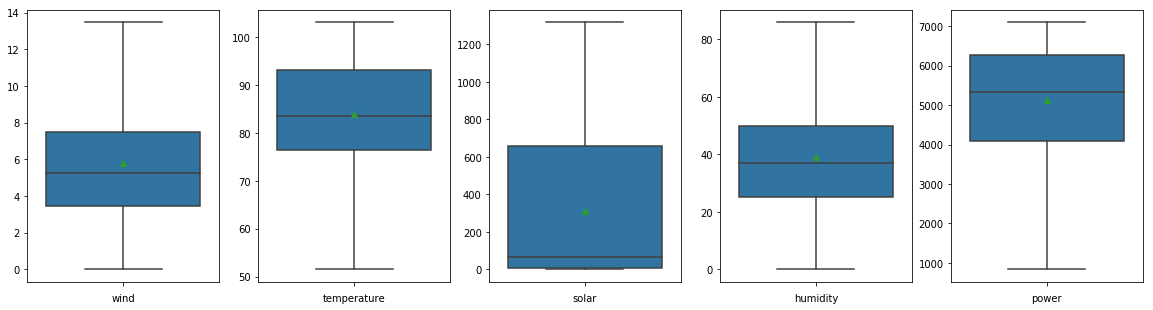

In [4]:
fig, ax_arr = plt.subplots(1, 5, figsize=((20, 5)))
variables = ['wind', 'temperature', 'solar', 'humidity', 'power']
for i, ax in enumerate(ax_arr):
    var = variables[i]
    sns.boxplot(y=var, data=data, 
                showmeans=True, showfliers=False, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel(var)
plt.show()

In [5]:
data[variables].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
wind,380107.0,5.797249,3.354542,-8.781063e-15,3.465816,5.255490,7.470503,23.104488
temperature,380107.0,83.924002,12.534455,-4.000000e+01,76.358055,83.630352,93.096285,103.105553
solar,380107.0,313.625594,377.298571,-2.695444e-10,8.110301,67.161087,657.714842,1317.918969
humidity,380107.0,39.217812,16.296445,-3.291698e-14,25.330173,37.159912,50.056655,85.928384
power,380107.0,5138.727569,1248.125151,-4.382715e+01,4090.644955,5328.696748,6264.580691,7099.686172


We can see that there are some negative values in each variable, those are outliers we need to filter out. We can also filter out points which are the 1.5 times interquartile range below 25 percentile and above 75 percentile.

In [6]:
def outlier_mask(var):
    # compute 25 and 75 percentile
    q25 = var.quantile(.25)
    q75 = var.quantile(.75)
    # interquartile range
    interquartile_range = q75 - q25
    upper = q75 + interquartile_range
    lower = max(q25 - interquartile_range, 0)
    return (var > upper) | (var < lower)

Filter out outliers

In [7]:
outlier_mask_df = data[variables].apply(outlier_mask)
# As long as there is a outlier in at least one variable, a whole row is thrown away
invalid_data_mask = outlier_mask_df.apply(any, axis=1)
# Filter raw data
data_filtered = data[~invalid_data_mask]
# reset the sample number: 
# drop original sample_num colunm, 
# groupby day and reset index to use re-index as sample number
# insert the re-index to columns
data_filtered = (data_filtered.drop('sample_num', axis=1)
                 .groupby('day', group_keys=False).apply(lambda g:g.reset_index(drop=True))
                 .reset_index().rename(columns={'index':'sample_num'}))
data_filtered[variables].describe()

,wind,temperature,solar,humidity,power
count,343060.000000,343060.000000,343060.000000,343060.000000,343060.000000
mean,5.272808,85.011782,341.823063,38.267210,5205.153925
std,2.481888,9.269158,384.489884,15.008193,1198.651405
min,0.187760,59.860548,0.000000,11.612810,1916.951821
25%,3.417636,76.841145,8.263144,25.004436,4103.826705
50%,5.088318,84.272376,132.325573,36.550124,5463.625158
75%,7.001496,93.633464,706.414885,49.436258,6304.901203
max,11.475087,103.105553,1306.345520,74.782992,7099.686172


In [8]:
data_filtered.head()

,sample_num,day,humidity,power,solar,temperature,wind
0,0,1,43.811749,5788.555960,1.406047,75.128491,1.739410
1,1,1,43.245738,5790.605704,0.468682,73.661096,2.189845
2,2,1,43.908135,5771.830051,5.757763,74.757276,2.194219
3,3,1,44.386841,5748.146726,8.530939,75.669341,2.409350
4,4,1,44.364088,5793.202046,6.914409,75.590562,2.230627


Let's plot one day's data for each variable.

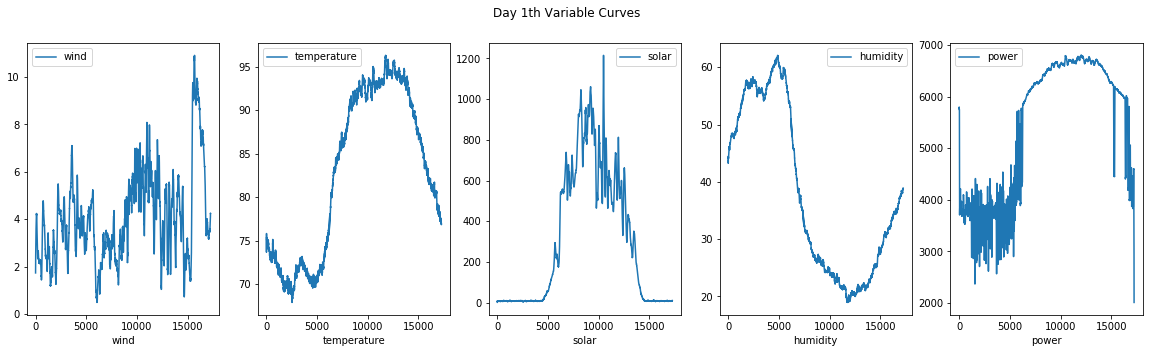

In [9]:
day_num = np.random.randint(len(set(data_filtered['day'].values))) + 1
data_day_one = data_filtered[data_filtered.day==day_num]

fig, ax_arr = plt.subplots(1, 5, figsize=((20, 5)))
variables = ['wind', 'temperature', 'solar', 'humidity', 'power']
for i, ax in enumerate(ax_arr):
    var = variables[i]
    data_day_one.plot(x='sample_num', y=var, ax=ax)
#     ax.set_ylabel('')
    ax.set_xlabel(var)
fig.suptitle("Day {}th Variable Curves".format(day_num))
plt.show()

From this plot, we can see that there are some fluctuations for each curve. This might be due to our small sampling period (5 seconds) and the sensor noise.

We can use a mean window to smooth our data curves. Since all the variables we measured shouldn't change very frequently in the outdoor environment, we can use a window size 120 (10 minutes) to smooth our data.

In [10]:
data_smoothed = (data_filtered.drop('sample_num', axis=1)
                 .groupby('day').rolling(120, 1).mean()
                 .drop('day', axis=1).reset_index(0)
                 .groupby('day', group_keys=False).apply(lambda g:g.reset_index(drop=True))
                 .reset_index().rename(columns={'index':'sample_num'}))

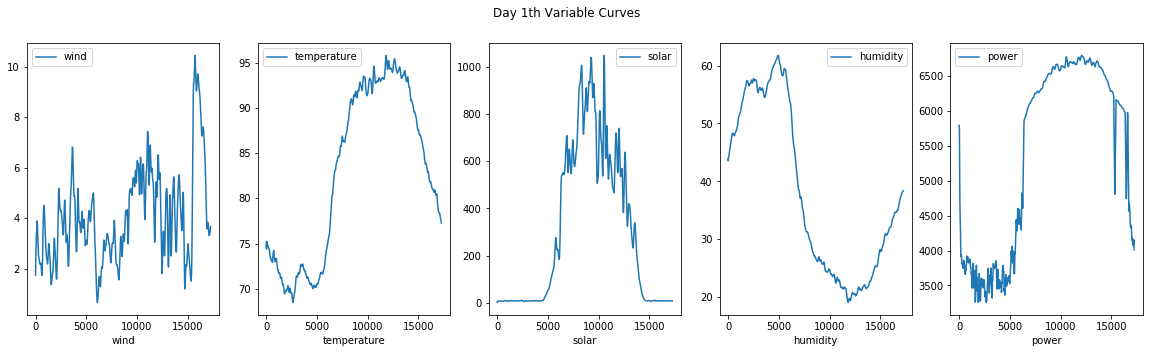

In [11]:
data_day_one = data_smoothed[data_smoothed.day==day_num]
fig, ax_arr = plt.subplots(1, 5, figsize=((20, 5)))
variables = ['wind', 'temperature', 'solar', 'humidity', 'power']
for i, ax in enumerate(ax_arr):
    var = variables[i]
    data_day_one.plot(x='sample_num', y=var, ax=ax)
#     ax.set_ylabel('')
    ax.set_xlabel(var)
fig.suptitle("Day {}th Variable Curves".format(day_num))
plt.show()

### Feature Exploration

Before building our prediction model, let's look at the correlations between these variables.

We sample 10% data and plot the scatter plot for each pair of variables.

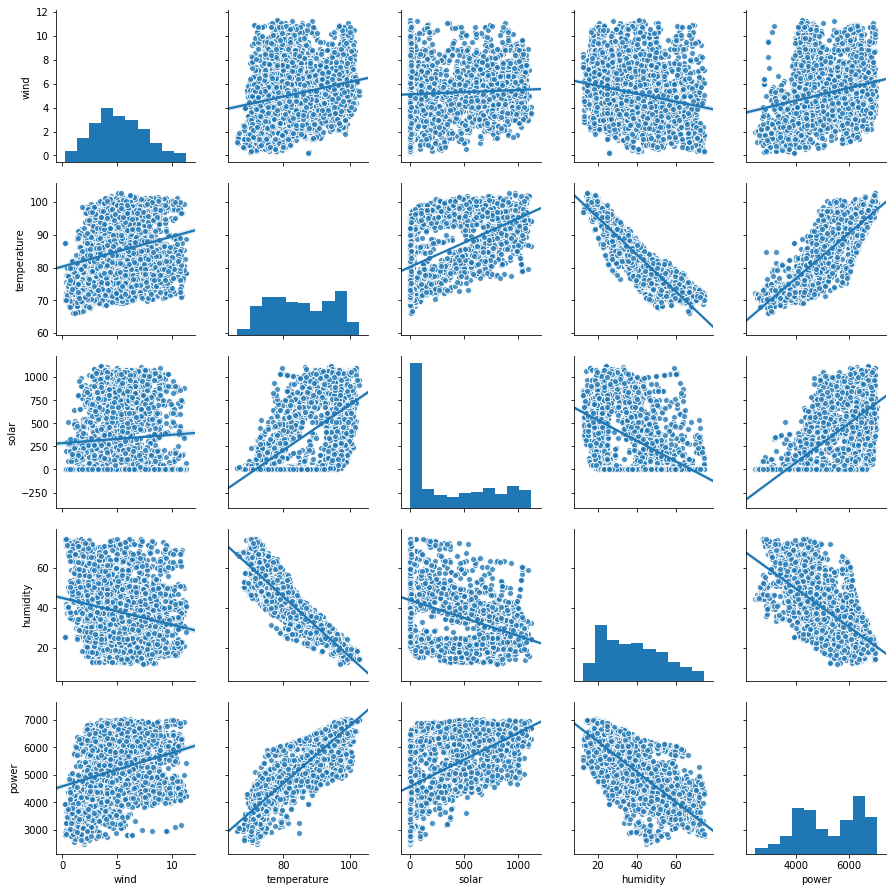

In [12]:
sns.pairplot(data_smoothed[variables].sample(frac=0.01), kind='reg', 
             plot_kws=dict(scatter_kws=dict(edgecolor="w")))
plt.show()

From the pairplot, we can see that there might be four linear relationship. Two are positive: _Temperature vs Power_, _Solar vs Power_ and two are negative: _Humidity vs Temperature_ and _Humidity vs Power_.

Let's compute the Pearson Correlation Coefficient (PCC).

In [14]:
corrmat = data[variables].corr()

Plot the heatmap

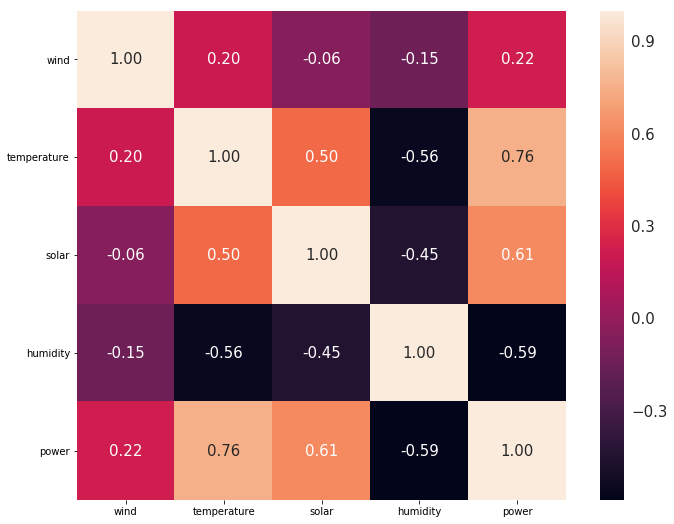

In [15]:
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.5)
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=variables, xticklabels=variables)
plt.yticks(rotation=0) 
plt.show()

**Feature Importance on Linear Regression**

In previous section, we saw that the _temperature_ has strong **PCC** with _power_. 

In this section, we are going to try all the feature combinations and use each combinations to train a **linear regression model** to see how each feature set impact on the Mean Square Error of predictions.

Split data into train and test. We hold out the data of the last two days as the test data. Then the training set is used to tune hyper-parameters through 5-folds cross validation.

In [13]:
data_train = data[data['day'] <= 20]
data_test = data[data['day'] > 20]
X_y_train = data_train[variables].values
X_y_test = data_test[variables].values

In [14]:
X_train = X_y_train[:, :-1]
y_train = X_y_train[:, -1]
X_test = X_y_test[:, :-1]
y_test = X_y_test[:, -1]

In [15]:
variables

['wind', 'temperature', 'solar', 'humidity', 'power']

Get all feature combinations

In [16]:
import itertools

feature_combinations = []
features = variables[:-1]
for n in range(len(features)):
    feature_combinations.extend(list(itertools.combinations(features, n + 1)))

In [17]:
feature_combinations

[('wind',),
 ('temperature',),
 ('solar',),
 ('humidity',),
 ('wind', 'temperature'),
 ('wind', 'solar'),
 ('wind', 'humidity'),
 ('temperature', 'solar'),
 ('temperature', 'humidity'),
 ('solar', 'humidity'),
 ('wind', 'temperature', 'solar'),
 ('wind', 'temperature', 'humidity'),
 ('wind', 'solar', 'humidity'),
 ('temperature', 'solar', 'humidity'),
 ('wind', 'temperature', 'solar', 'humidity')]

For each feature set, we will do a 5-fold cross validation to tune the hyper-parameters, then the best average result across all folds will be used as the metric score of this set of features.

In [18]:
from scipy.stats import uniform
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

X_train_df = pd.DataFrame(X_train, columns=features)
# parameter grid
alpha = uniform(0, 100)
l1_ratio = uniform(0, 1)
parameters = {'alpha':alpha, 'l1_ratio':l1_ratio}
best_scores = []
for feature_set in feature_combinations:
    feature_set = list(feature_set)
    X_train_features = X_train_df[feature_set].values
    lr_model = ElasticNet(fit_intercept =True)
    clf = RandomizedSearchCV(lr_model, parameters, scoring='neg_mean_squared_error',
                             cv=5)
    clf.fit(X_train_features, y_train)
    best_score = clf.best_score_
    best_scores.append(best_score)

Sort the best scores and print the rank

In [19]:
print(np.array(feature_combinations)[np.argsort([-score for score in best_scores])])

[('wind', 'temperature', 'solar', 'humidity')
 ('temperature', 'solar', 'humidity') ('wind', 'temperature', 'solar')
 ('temperature', 'solar') ('wind', 'temperature', 'humidity')
 ('temperature', 'humidity') ('wind', 'temperature') ('temperature',)
 ('wind', 'solar', 'humidity') ('solar', 'humidity') ('wind', 'solar')
 ('solar',) ('wind', 'humidity') ('humidity',) ('wind',)]


From this rank, we can see the importance rank for features based on prediction errors are:
- Temperature > Solar > Humidity > Wind

**Decision Tree Importance**

We can also build a decision tree regressor and decide the feature importance based on its Gini importance.

In [21]:
from scipy.stats import uniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# parameter grid
max_depth = [2, 4, 6, 8]
parameters = {'max_depth':max_depth}

dt_model = DecisionTreeRegressor()
clf = GridSearchCV(dt_model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

dt_importance = clf.best_estimator_.feature_importances_

In [22]:
print(np.array(features)[np.argsort([-importance for importance in dt_importance])])

['temperature' 'solar' 'humidity' 'wind']


We can see the same rank! Let's plot it.

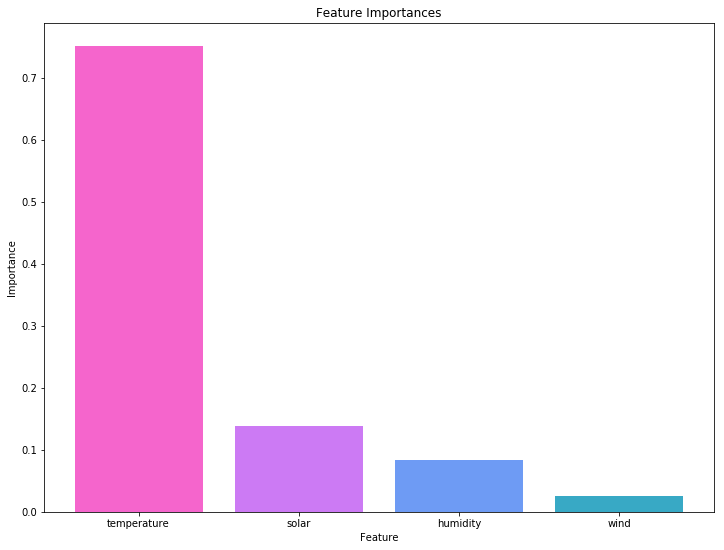

In [23]:
f, ax = plt.subplots(figsize=(12, 9))
features_sorted = np.array(features)[np.argsort([-importance for importance in dt_importance])]
importances_sorted = dt_importance[np.argsort([-importance for importance in dt_importance])]
x_corr = list(range(len(importances_sorted)))
colors = ['#f565cc', '#cc7af4', '#6e9bf4', '#38a9c5']
plt.bar(x_corr, importances_sorted, color=colors)
plt.xticks(x_corr, features_sorted)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
plt.show()

### Build Prediction Models

Let's build several regression models. Since we see that several features are linearly correlated with the power variable, we choose the linear regression as our baseline model.

**Linear Regression**

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

alpha = uniform(0, 100)
l1_ratio = uniform(0, 1)

lr_model = ElasticNet(fit_intercept =True)
parameters = {'alpha':alpha, 'l1_ratio':l1_ratio}
clf = RandomizedSearchCV(lr_model, parameters, n_iter=50, 
                         scoring='neg_mean_squared_error', cv=5,
                         n_jobs=-1)

clf.fit(X_train, y_train)
lr_best_params = clf.best_params_
lr_best_model = clf.best_estimator_
coefficients = lr_best_model.coef_
intercept = lr_best_model.intercept_

In [25]:
print(lr_best_params)

{'alpha': 22.40112759075641, 'l1_ratio': 0.33593277618913897}


In [26]:
linear_function = str(intercept)
for i, pair in enumerate(zip(features, coefficients)):
    coef = str(abs(pair[1]))
    if pair[1] > 0:
        sym = ' + '
    else:
        sym = ' - '
    var = pair[0]
    linear_function += sym + coef + "*" + var     

In [28]:
print('best parameters:', lr_best_params)
print('Linear Function:', linear_function)

best parameters: {'alpha': 22.40112759075641, 'l1_ratio': 0.33593277618913897}
Linear Function: 1631.2438351050828 + 22.10942807307591*wind + 44.046267312294724*temperature + 1.0175499741239997*solar - 15.373815374989066*humidity


In [29]:
from sklearn.metrics import mean_squared_error

y_true = y_test
y_pred = lr_best_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

661.534018248573


**Decision Tree**

In [38]:
# parameter grid
max_depth = [2, 4, 8, 10, 12]
parameters = {'max_depth':max_depth}

dt_model = DecisionTreeRegressor()
clf = GridSearchCV(dt_model, parameters, scoring='neg_mean_squared_error', cv=5,
                   n_jobs=-1)
clf.fit(X_train, y_train)
dt_best_params = clf.best_params_
dt_best_model = clf.best_estimator_

In [39]:
print(dt_best_params)

{'max_depth': 4}


In [40]:
y_true = y_test
y_pred = dt_best_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

717.1928709544985


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# parameter grid
max_depth = [2, 4, 6, 8, 10, 12]
n_estimators = [10, 20, 50, 80, 100, 150, 200]
parameters = {'max_depth':max_depth, 'n_estimators':n_estimators}

rf_model = RandomForestRegressor()
clf = GridSearchCV(rf_model, parameters, scoring='neg_mean_squared_error', cv=5,
                   n_jobs=-1)
clf.fit(X_train, y_train)
rf_best_params = clf.best_params_
rf_best_model = clf.best_estimator_

In [104]:
print(rf_best_params)

{'max_depth': 4, 'n_estimators': 100}


In [35]:
y_true = y_test
y_pred = dt_best_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

717.1928709544804


**Gradient Boosting Trees**

In [96]:
from sklearn.ensemble import GradientBoostingRegressor

# parameter grid
max_depth = [2, 4, 6, 8, 10, 12]
n_estimators = [10, 20, 50, 80, 100, 150, 200]
parameters = {'max_depth':max_depth, 'n_estimators':n_estimators}

gb_model = GradientBoostingRegressor()
clf = RandomizedSearchCV(gb_model, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=4)
clf.fit(X_train, y_train)
gb_best_params = clf.best_params_
gb_best_model = clf.best_estimator_

In [105]:
print(gb_best_params)

{'n_estimators': 80, 'max_depth': 2}


In [97]:
y_true = y_test
y_pred = gb_best_model.predict(X_test)
print(np.sqrt(mean_squared_error(y_true, y_pred)))

644.6792452124558


Compute the absolute relative error and make plots.

In [98]:
data_pred = data_test.loc[:, ['day', 'power']].rename(columns={'power':'Actual Power'})
data_pred['MLR-ElasticNet'] = lr_best_model.predict(X_test)
data_pred['DecisionTree'] = dt_best_model.predict(X_test)
data_pred['RandomForest'] = rf_best_model.predict(X_test)
data_pred['GradientBoosting'] = gb_best_model.predict(X_test)
data_pred = data_pred.melt(id_vars=['day','Actual Power'], 
               var_name='Algorithm',
               value_name='Predicted Power')
data_pred['Absolute Relative Error'] = abs(data_pred['Actual Power'] - data_pred['Predicted Power']) / data_pred['Actual Power']

In [99]:
# set tick and labels based on two days data
xticks_value = tuple([x*1440 for x in range(25)])
xticks_labels = tuple([x*2 for x in range(25)])

MLR

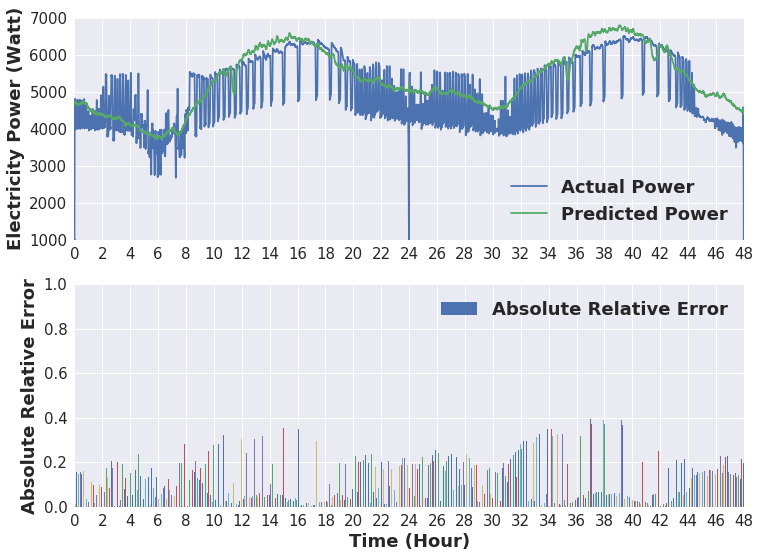

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
# plot ax1
ax1 = data_pred.loc[data_pred['Algorithm']=='MLR-ElasticNet', ['Actual Power','Predicted Power']].plot(ax=ax1)

# set xticks 
ax1.set_xticks(xticks_value)

ax1.set_xticklabels(xticks_labels, rotation=0)
ax1.set_ylabel('Electricity Power (Watt)', fontweight='bold', fontsize = 'medium')
ax1.legend(loc='best', prop={'size': 'medium', 'weight': 'bold'})
ax1.set_ylim([1000, 7000])
ax1.set_xlim([0, xticks_value[-1]])

ax2 = data_pred.loc[data_pred['Algorithm']=='MLR-ElasticNet', 'Absolute Relative Error'].plot(ax=ax2,kind='bar')
ax2.set_ylim([0, 1])
ax2.set_xticks(xticks_value)
ax2.set_xticklabels(xticks_labels, rotation=0)
ax2.set_xlabel('Time (Hour)', fontweight='bold',fontsize = 'medium')
ax2.set_ylabel('Absolute Relative Error', fontweight='bold', fontsize = 'medium')
ax2.legend(loc='best',prop={'size': 'medium', 'weight':'bold'})
plt.show()
# plt.savefig(os.path.join('.', 'figures', 'dtPredictions_Error.png'), bbox_inches = 'tight')

DT

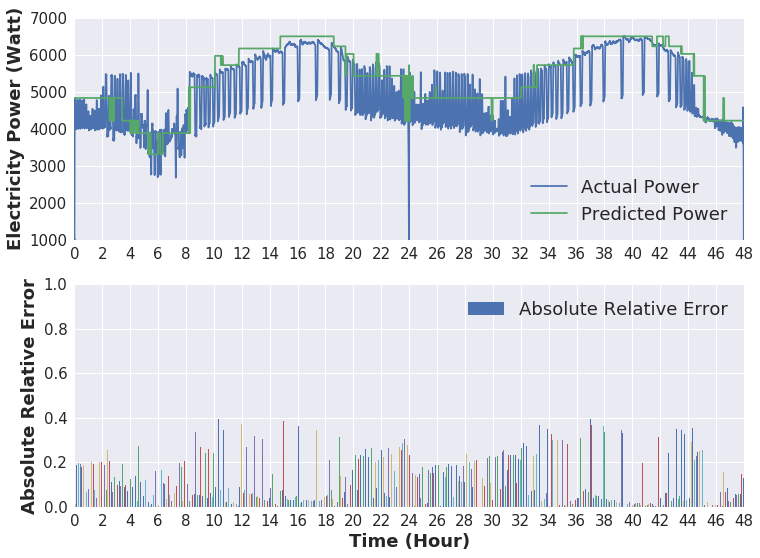

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
# plot ax1
ax1 = data_pred.loc[data_pred['Algorithm']=='DecisionTree', ['Actual Power','Predicted Power']].reset_index(drop=True).plot(ax=ax1)

# set xticks 
ax1.set_xticks(xticks_value)

ax1.set_xticklabels(xticks_labels, rotation=0)
ax1.set_ylabel('Electricity Power (Watt)', fontweight='bold', fontsize = 'medium')
ax1.legend(loc='best', prop={'size': 'medium'})
ax1.set_ylim([1000, 7000])
ax1.set_xlim([0, xticks_value[-1]])

ax2 = data_pred.loc[data_pred['Algorithm']=='DecisionTree', 'Absolute Relative Error'].plot(ax=ax2,kind='bar')
ax2.set_ylim([0, 1])
ax2.set_xticks(xticks_value)
ax2.set_xticklabels(xticks_labels, rotation=0)
ax2.set_xlabel('Time (Hour)', fontweight='bold',fontsize = 'medium')
ax2.set_ylabel('Absolute Relative Error', fontweight='bold', fontsize = 'medium')
ax2.legend(loc='best',prop={'size': 'medium'})
plt.show()

RF

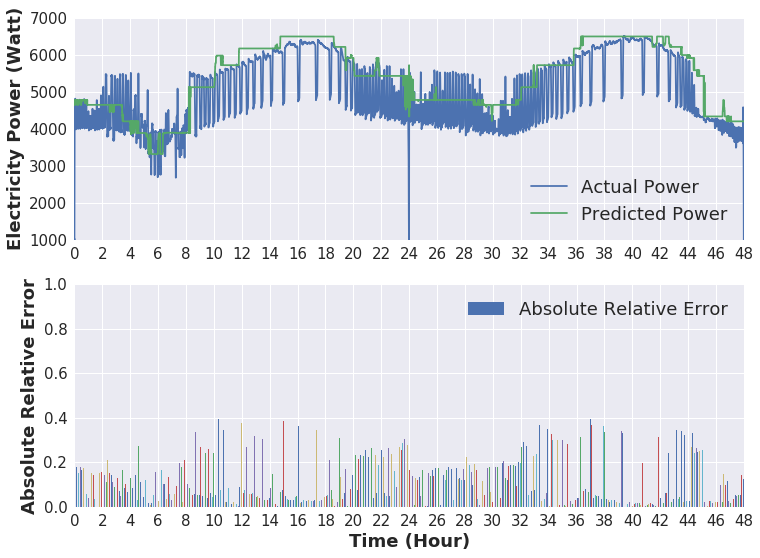

In [94]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
# plot ax1
ax1 = data_pred.loc[data_pred['Algorithm']=='RandomForest', ['Actual Power','Predicted Power']].reset_index(drop=True).plot(ax=ax1)

# set xticks 
ax1.set_xticks(xticks_value)

ax1.set_xticklabels(xticks_labels, rotation=0)
ax1.set_ylabel('Electricity Power (Watt)', fontweight='bold', fontsize = 'medium')
ax1.legend(loc='best', prop={'size': 'medium'})
ax1.set_ylim([1000, 7000])
ax1.set_xlim([0, xticks_value[-1]])

ax2 = data_pred.loc[data_pred['Algorithm']=='RandomForest', 'Absolute Relative Error'].plot(ax=ax2,kind='bar')
ax2.set_ylim([0, 1])
ax2.set_xticks(xticks_value)
ax2.set_xticklabels(xticks_labels, rotation=0)
ax2.set_xlabel('Time (Hour)', fontweight='bold',fontsize = 'medium')
ax2.set_ylabel('Absolute Relative Error', fontweight='bold', fontsize = 'medium')
ax2.legend(loc='best',prop={'size': 'medium'})
plt.show()

GB

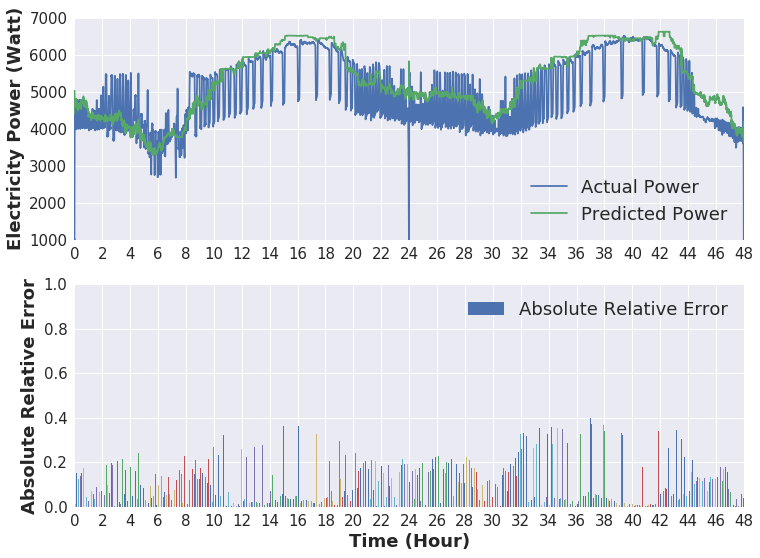

In [100]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
# plot ax1
ax1 = data_pred.loc[data_pred['Algorithm']=='GradientBoosting', ['Actual Power','Predicted Power']].reset_index(drop=True).plot(ax=ax1)

# set xticks 
ax1.set_xticks(xticks_value)

ax1.set_xticklabels(xticks_labels, rotation=0)
ax1.set_ylabel('Electricity Power (Watt)', fontweight='bold', fontsize = 'medium')
ax1.legend(loc='best', prop={'size': 'medium'})
ax1.set_ylim([1000, 7000])
ax1.set_xlim([0, xticks_value[-1]])

ax2 = data_pred.loc[data_pred['Algorithm']=='GradientBoosting', 'Absolute Relative Error'].plot(ax=ax2,kind='bar')
ax2.set_ylim([0, 1])
ax2.set_xticks(xticks_value)
ax2.set_xticklabels(xticks_labels, rotation=0)
ax2.set_xlabel('Time (Hour)', fontweight='bold',fontsize = 'medium')
ax2.set_ylabel('Absolute Relative Error', fontweight='bold', fontsize = 'medium')
ax2.legend(loc='best',prop={'size': 'medium'})
plt.show()

Boxplot of absolute relative error

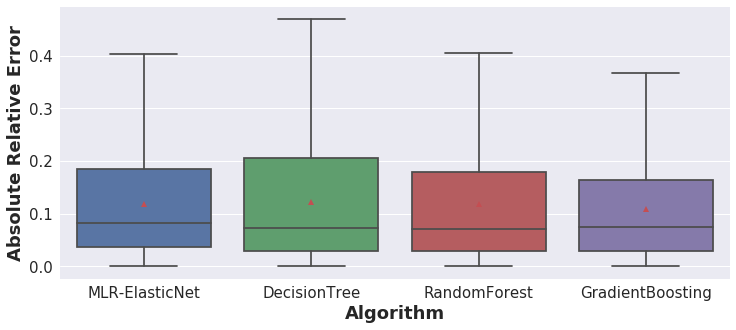

In [101]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = sns.boxplot(x='Algorithm', y="Absolute Relative Error", data=data_pred, showmeans=True, showfliers=False, ax=ax)

plt.xlabel('Algorithm',fontweight='bold', fontsize='medium')
plt.ylabel('Absolute Relative Error', fontweight='bold',fontsize='medium')

plt.show()